# Follow-up

This tab provides an overview of the clinical trial status, ie. number of patients, median follow-up times, total data, missing data, etc, and details by group. 

In [1]:
import os
import sys
sys.path.append("C:\\Users\\Fabien Boux\\Code\\ClinLib")

from functions.config import Config
from clinlib.database import Database

with open('init.txt') as f:
    lines = f.readlines()
config = Config(lines[0])
config.read()

database = Database(config.get_value('database', section='PATH'), idlength=(int(config.get_value('id_length', section='OTHER')) if config.is_key('id_length') else 3))
database.add_resource({'metadata': os.path.join(config.get_value('database', section='PATH'), config.get_value('metadata', section='PATH'))})

import ipywidgets as widgets
from ipywidgets import interact, interactive
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
import pandas as pd
import numpy as np

metadata = database.get_metadata(which='all')

group = metadata['Group']
group_labels = group.dropna().unique()

df = pd.DataFrame([], columns=list(group_labels) + ['Overall'])

df.loc['Number of patients'] = [(metadata['Group'] == g).sum() for g in group_labels] + [len(metadata['Group'])]
df.loc['including censored'] = [metadata['End'][metadata['Group'] == g].isna().sum() for g in group_labels] + [metadata['End'].isna().sum()]
df.loc['Median follow-up (days)'] = [(metadata['End'][metadata['Group'] == g] - metadata['Start'][metadata['Group'] == g]).median().days for g in group_labels] + [(metadata['End'] - metadata['Start']).median().days]

list_files = [f.split('.')[0] for f in os.listdir(database.folders['data']) if os.path.isfile(os.path.join(database.folders['data'], f))]
for i in metadata.index:
    if metadata.loc[i, 'Patient'] in list_files:
        metadata.loc[i, 'File'] = True
        
        xls = pd.ExcelFile(os.path.join(database.folders['data'], metadata.loc[i, 'Patient'] + '.xlsx'))
        visits = []
        for sheet_name in xls.sheet_names:
            if 'Session' in xls.parse(sheet_name).columns:
                visits = visits + list(xls.parse(sheet_name)['Session'].unique())
        metadata.loc[i, 'Visits'] = len(set(visits))
        metadata.loc[i, 'Missing'] = 0
    else:
        metadata.loc[i, 'File'] = False
        metadata.loc[i, 'Visits'] = 0
        metadata.loc[i, 'Missing'] = 0
        

df.loc['Patient with data'] = [metadata['File'][metadata['Group'] == g].sum() for g in group_labels] + [metadata['File'].sum()]
df.loc['Number of visits'] = [metadata['Visits'][metadata['Group'] == g].sum() for g in group_labels] + [metadata['Visits'].sum()]
df.loc['and missing visits'] = [metadata['Missing'][metadata['Group'] == g].sum() for g in group_labels] + [metadata['Missing'].sum()]

def df_style(val):
    return "font-weight: bold"

df = df.astype(int)
df.style.applymap(df_style, subset='Overall')

,AGuIX,WBRT,Overall
Number of patients,31,31,87
including censored,11,9,45
Median follow-up (days),153,126,131
Patient with data,23,24,47
Number of visits,114,82,196
and missing visits,0,0,0


The following plot is a *swimmer plot*. This graph allows a fast overview of all data, it combines time-to-event (patient's treatment, death or end of the follow-up) and imaging (via lesion evolutions if available).
Note that some variables used in this graph can be defined in the ```Configuration``` tab (the follow-up time, list of potential visits, etc). If these options are missing, the graph only contains the time-related data.

C:\ProgramData\Anaconda3\envs\NanoRad\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


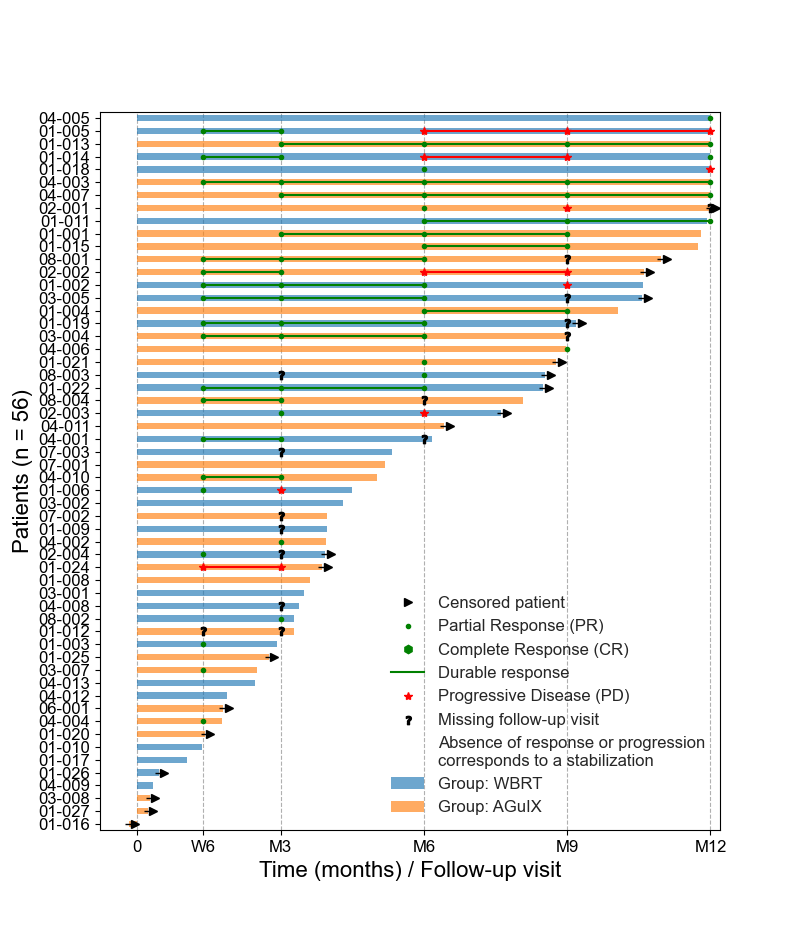

In [3]:
%matplotlib widget

from functions.graph import swimmer_plot

followup = (float(config.get_value('followup')) / (365 / 12) if config.is_key('followup') else None)
visits = (config.get_value('visits') if config.is_key('visits') else  None)
metric = (config.get_value('volume_label') if config.is_key('volume_label') else 'Volume')
groups = (config.get_value('groups') if config.is_key('groups') else None)
    
swimmer_plot(database, followup_time=followup, followup_visits=visits, metric=metric, groups=groups);